# __ACA centroiding__

### Goals

1. Replicate the on-board PEA centroids ('raw centroids'):

    * access level0 raw images,
    
    * compute first moments for background subtracted images,
    
    * compare the raw centroids with the telemetered values (aoacyan, aoaczan).<br><br>

2. Apply a Gassian mask to the raw images to assign higher weigt to the central pixels. Check if this improves ACA centroiding for faint stars.

### Results

1. PEA centroids replicated to the accuracy of 0.01 arcsec (standard deviation of the residuals) even for faint stars (10.2 mag) with high background noise.<br><br>

2. However, no improvement to centroiding when a weighting mask is used. The residuals show spikes corresponding to <code>IMGCOL0</code> and/or <code>IMGROW0</code> changing by ~1px due to the drift of the image withing the ACA window, while the weighting mask is static and centered in the 8x8 pixel image.

In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
from astropy.table import Table
import astropy.units as u
from kadi import events
from mica.archive import aca_l0
import Ska.engarchive.fetch as fetch
from chandra_aca import transform
from Chandra.Time import DateTime
import Ska.Numpy
from mica import quaternion
import pyyaks.logger
import numpy.ma as ma

### Definitions of functions used in the notebook

* Build an 8x8 average background image with relevant rows/columns masked (depending on the type of observation, science vs. ER), and 6x6 mousebitten corners.


* Define weighting masks to assign more importance to the central pixels.


* Compute centroids of raw images using first moments or a weighting mask. Compare with telemetry and compute some statistics: residuals, and standard deviation of residuals.

In [2]:
# create 8x8 bgd arrays for bgd subtraction
# centered=True:: the 1:7 'corners' are set to zero, relevant for the ER observations
# centered=False:: the 0:6 'corners' are set to zero, relevant for the science observations
def get_bgd_image_8x8(avbgd, centered=True):
    bgd_img = (avbgd * np.ones(64))
    bgd_img = zero_6x6_corners(bgd_img, centered=centered)
    return bgd_img.reshape(8, 8)


def zero_6x6_corners(img, centered=True): # img is a 64-element array before reshaping
    if len(img) != 64:
        raise "Img should be a 64-element array"
    if centered:
        corners = [9, 14, -10, -15] # 1:7
    else:
        corners = [0, 5, -19, -24] # 0:6        
    for i in corners:
        img[i] = 0.0
    return img


# Mask edge pixels in 8x8 image, leave the central 6x6 part unmasked,
# relevant for the ER observations.
# Note that for science observations the raw image is masked by default,
# but rows/columns 0:6 are left unmasked.
def get_mask_8x8_centered():
    mask = np.zeros(64)
    mask = mask.reshape(8, 8)
    mask[0] = 1
    mask[-1] = 1
    for i in range(7):
        mask[i][0] = 1
        mask[i][-1] = 1
    return mask


# Define a simple mask that assigns more importance to the central pixels
def get_weighting_mask_8x8_centered():
    """
    0 1 1 1 1 0
    1 2 2 2 2 1
    1 2 3 3 2 1
    1 2 3 3 2 1
    1 2 2 2 2 1
    0 1 1 1 1 0
    """
    mask = get_mask_8x8_centered()
    aa = [1, 2, 2, 1]
    for index, i in enumerate([1, 2, 5, 6]):
        mask[i][2:6] = aa[index]
    for i in [1, 6]:
        mask[i][1] = 0
        mask[i][-2] = 0       
    for i in [2, 5]:
        mask[i][1] = 1
        mask[i][-2] = 1
    for i in [3, 4]:
        mask[i][1] = 1
        mask[i][-2] = 1
        mask[i][2] = 2
        mask[i][-3] = 2
        mask[i][3] = 3
        mask[i][-4] = 3
    return mask


# Define a Gaussian mask
def gaussian_kernel_tile(size):
    # This is a 4x4 tile, with Gassian centered in a corner
    # Full mask is a composition of 4 tiles
    size = int(size)
    x, y = np.mgrid[0:size, 0:size]
    g = np.exp(-(x**2/float(size)+y**2/float(size)))
    return g / g.sum() / 4 # 1/4 of the whole kernel


def gaussian_kernel_8x8(size):
    # returns an 8x8 array
    # size = 6: a 6x6 centered kernel will be normalized to 1
    # size = 8: a full 8x8 kernel will be normalized to 1
    
    size = int(size)
    if size not in [8, 6]:
        raise "Kernel size should be 6 or 8 (for 6x6 or 8x8 mask)."

    gaussian_kernel_array = np.zeros(64).reshape(8, 8)

    halfsize = int(size / 2)
    tile_top_right = gaussian_kernel_tile(halfsize)    
    tile_top_left = np.fliplr(tile_top_right)
    tile_bottom_left = np.flipud(tile_top_left)
    tile_bottom_right = np.flipud(tile_top_right)

    a = 4 - halfsize
    b = size + 1
    gaussian_kernel_array[4:b, 4:b] = tile_top_right
    gaussian_kernel_array[4:b, a:4] = tile_top_left
    gaussian_kernel_array[a:4, a:4] = tile_bottom_left
    gaussian_kernel_array[a:4, 4:b] = tile_bottom_right
 
    return gaussian_kernel_array


# wmask = None in case of simple first moment centroiding
def calc_raw_centroids_stats(slots, method='first_moment', wmask=None):
        
    if method not in ['first_moment', 'weighting_mask']:
        raise "Unrecognized method, choose first_moment or weighting_mask" 
    
    rows = []

    for slot in slots:
    
        slot_row = {'slot':slot, 'mean_mags':[],
                    'yan_raw':[], 'zan_raw':[],
                    'yan_resids':[], 'zan_resids':[],
                    'yan_stds':[], 'zan_stds':[]}

        slot_data = aca_l0.get_slot_data(d.start, d.stop, slot=slot)
        slot_data = Table(slot_data)
        raw_images = slot_data['IMGRAW']
        bgdav = slot_data['BGDAVG']
        row0 = slot_data['IMGROW0']
        col0 = slot_data['IMGCOL0']
        time = slot_data['TIME']
    
        slot_row['row0'] = row0
        slot_row['col0'] = col0
        slot_row['time'] = time

        # Take all images
        num_imgs = len(raw_images)
        
        # Calculate raw centroids
        centroids = get_raw_centroids(raw_images, bgdav, img_size, num_imgs, img_mask, wmask=wmask)
            
        # Translate (row, column) centroid to (yag, zag)
        y_pixels = centroids[0] + row0[:num_imgs]
        z_pixels = centroids[1] + col0[:num_imgs]
        (slot_row['yan_raw'], slot_row['zan_raw']) = transform.pixels_to_yagzag(y_pixels, z_pixels)

        msids = [key + '{}'.format(slot) for key in ['aoacyan', 'aoaczan', 'aoacmag']]
        telem = fetch.MSIDset(msids, start=d.start, stop=d.stop)
    
        slot_row['mean_mags'].append(np.mean(telem['aoacmag{}'.format(slot)].vals))
    
        dt = -2.4    
    
        for msid in msids[:2]:
            telem_interp = Ska.Numpy.interpolate(telem[msid].vals, telem[msid].times + dt, time,
                                                 method="nearest")
            d_ags = slot_row['{}_raw'.format(msid[4:7])] - telem_interp
            resid = d_ags - np.median(d_ags)
            std = np.std(resid)
            slot_row['{}_resids'.format(msid[4:7])].append(resid)
            slot_row['{}_stds'.format(msid[4:7])].append(std)
                   
        rows.append(slot_row)
        
    return rows


# img_size = 6:: science observation (this may not work in case of slots with FIDs)
# img_size = 8:: ER observation
# img_mask = None for science observations
def get_raw_centroids(raw_images, bgdav, img_size, num_imgs, img_mask=None, wmask=None):
    
    if img_size not in [6, 8]:
        raise "Image size outside of allowed values [6, 8] (6x6 or 8x8)"
        
    num = np.arange(0.5, 6.5)
    centroids = []

    for index, raw_img in enumerate(raw_images[:num_imgs]):
        if (img_size == 6): # 6x6
            bgd_img = get_bgd_image_8x8(bgdav[index], centered=False)
        else: # 8x8
            bgd_img = get_bgd_image_8x8(bgdav[index], centered=True)
            raw_img = zero_6x6_corners(raw_img, centered=True)

        raw_img = raw_img.reshape(8, 8, order='F')
        img = raw_img - bgd_img
        
        if img_mask is not None:
            img = ma.array(img, mask=img_mask)

        if wmask is not None:
            img = np.multiply(img, wmask)
            
        pair = []
        for ax in [0, 1]:
            flat = np.sum(img, axis=ax)
            if (img_size == 6):            
                centroid = np.sum(flat[:-2] * num) / np.sum(flat[:-2])  # 0:6
            else:
                centroid = np.sum(flat[1:-1] * num) / np.sum(flat[1:-1])  # 1:7           
            pair.append(centroid)
        
        centroids.append(pair)
    
    centroids = np.array(centroids).T
    
    return centroids

### Plotting functions

In [3]:
# Plotting functions

def plot_resids(t):
    fig = plt.figure(figsize=(10, 20))

    for slot in slots:
        for key in ['yan', 'zan']:
            plt.subplot(4, 2, slot + 1)
            plt.plot(t['time'][slot], t[key + '_resids'][slot][0],
                     label='{}, std = {:.3f}'.format(key, t[key + '_stds'][slot][0]))

        plt.ylim(-0.052, 0.052)
        plt.legend()
        plt.title("obsid {}, slot {}".format(obsid, slot))
        plt.ylabel("Resid (arcsec)")
        plt.xlabel("Time (sec)")

    plt.subplots_adjust(left=0.05, bottom=0.2, right=0.99, top=0.9, hspace=0.3, wspace=0.3)
    return


def plot_d_ang(key, dt, t1, t2=None):
    # plot delta yan(or zan)
    ylim = [(76, 82), (2272, 2278)]
    fig = plt.figure(figsize=(10, 20))
    
    if t2 is None:
        t2 = t1
    
    for i, slot in enumerate([4, 7]):
        plt.subplot(4, 2, i + 1)
        ang_interp = Ska.Numpy.interpolate(t2[key][slot], t2['time'][slot] + dt[i], t1['time'][2], 
                                           method="nearest")
        d_ang = t1[key][2] - ang_interp
        plt.plot(t1['time'][2], d_ang, color='Darkorange',
                label='std = {:.5f}'.format(np.std(d_ang - np.median(d_ang))))
        plt.ylim(ylim[i])
        plt.xlabel('Time (sec)')
        plt.ylabel('delta {} (arcsec)'.format(key))
        plt.title('Slot 2 - Slot {}'.format(slot))
        plt.legend()

    plt.subplots_adjust(left=0.05, bottom=0.2, right=0.99, top=0.9, hspace=0.3, wspace=0.3)
    return


def plot_wmask(wmask):
    plt.imshow(wmask, cmap=plt.get_cmap('jet'), interpolation='nearest', origin='lower')
    plt.colorbar()
    #plt.show()
    return

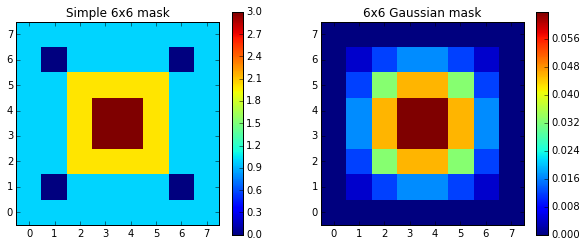

In [4]:
fig = plt.figure(figsize=(10, 4))

masks = [get_weighting_mask_8x8_centered(), gaussian_kernel_8x8(6)]
titles = ['Simple 6x6 mask', '6x6 Gaussian mask']

for i, mask in enumerate(masks):
    plt.subplot(1, 2, i + 1)
    plt.title(titles[i])
    plot_wmask(mask)

### Computations

In [5]:
# For obsids with 'bad or not tracking values'
# use screening as in get_archive_data, telems[msid].bads
# (not implemented here yet)

slots = range(8)

# 50804, stars in all slots tracked
obsid = 50804
img_size = 8
img_mask = get_mask_8x8_centered()

d = events.dwells.filter(obsid=obsid)[0]

Check if stars are tracked:

In [6]:
msids = ["aoacfct{}".format(slot) for slot in range(8)]
dat = fetch.MSIDset(msids, start=d.start, stop=d.stop)

print 'TRAK:'
print [dat[msid].vals.tolist().count('TRAK') for msid in msids]
print 'RACQ:'
print [dat[msid].vals.tolist().count('RACQ') for msid in msids]
print 'SRCH:'
print [dat[msid].vals.tolist().count('SRCH') for msid in msids]

TRAK:
[3107, 3107, 3107, 3107, 3107, 3107, 3107, 3107]
RACQ:
[0, 0, 0, 0, 0, 0, 0, 0]
SRCH:
[0, 0, 0, 0, 0, 0, 0, 0]


In [7]:
rows_fm = calc_raw_centroids_stats(slots, method='first_moment')

In [8]:
t = Table(rows_fm)
t['yan_stds'].format = '%.4f'
t['zan_stds'].format = '%.4f'
t['mean_mags'].format = '%.4f'

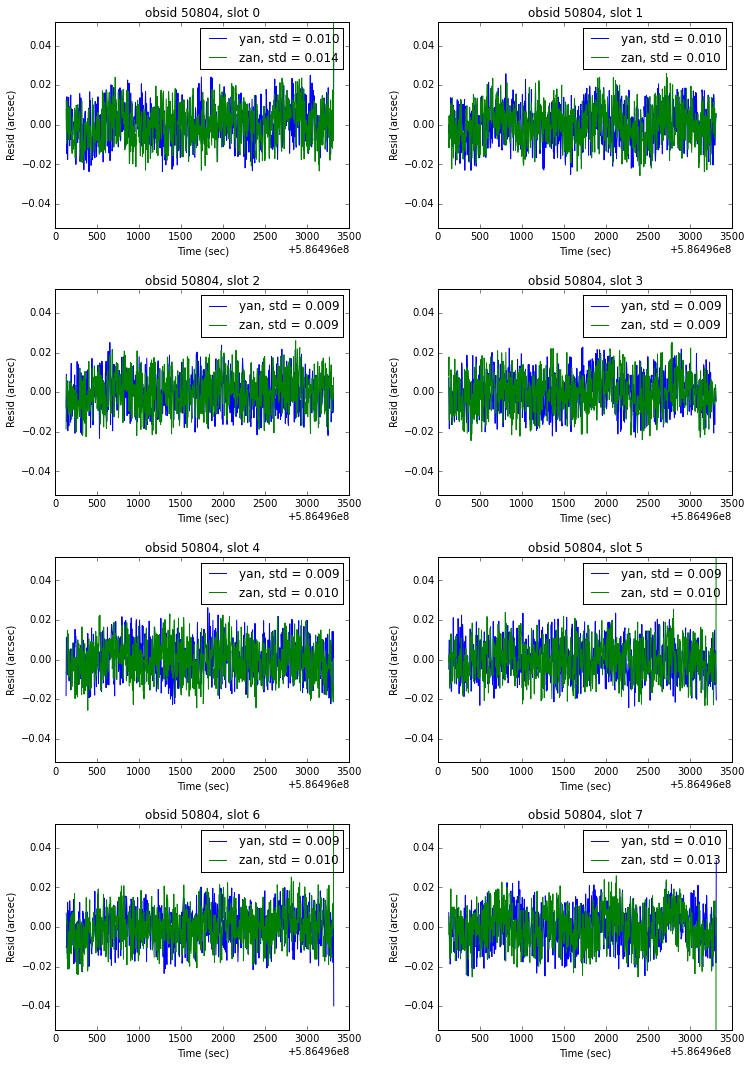

In [9]:
plot_resids(t)

In [10]:
print t.colnames
print
print t['slot', 'yan_stds', 'zan_stds', 'mean_mags']

aa = t['col0'][0][0]
print
print "IMGCOL0 in slot 0 = {} in {} of {} entries.".format(aa,
                                                           t['col0'][0].tolist().count(aa),
                                                           len(t['col0'][0]))
print "max = {}, min = {}.".format(np.max(t['col0'][0]), np.min(t['col0'][0]))

['col0', 'mean_mags', 'row0', 'slot', 'time', 'yan_raw', 'yan_resids', 'yan_stds', 'zan_raw', 'zan_resids', 'zan_stds']

slot yan_stds [1] zan_stds [1] mean_mags [1]
---- ------------ ------------ -------------
   0       0.0096       0.0142        9.3948
   1       0.0098       0.0097        8.5798
   2       0.0091       0.0094        8.1592
   3       0.0094       0.0095        9.2761
   4       0.0092       0.0095        7.4157
   5       0.0094       0.0102        8.2675
   6       0.0090       0.0100        9.0124
   7       0.0098       0.0133       10.2580

IMGCOL0 in slot 0 = -33 in 151 of 777 entries.
max = -31, min = -35.


__ Remove dither pattern __

Two brightest stars in slots 4 and 2, respectively. The faintest star in slot 7.

Simplified method of removing the dither pattern: subtract raw centroids from two different slots after interpolating to a common time axis. Use <code>[Slot4 - Slot2]</code> and <code>[Slot2 - Slot7]</code> for comparison.

In [11]:
print (t['time'][2] - t['time'][4])[:5]
print (t['time'][2] - t['time'][7])[:5]
dt = [0, -2.05] # shift in sec between time axes for slot pairs (2, 4) and (2, 7)

[ 0.  0.  0.  0.  0.]
[-2.05000019 -2.04999995 -2.05000019 -2.05000019 -2.04999995]


Method: first moment


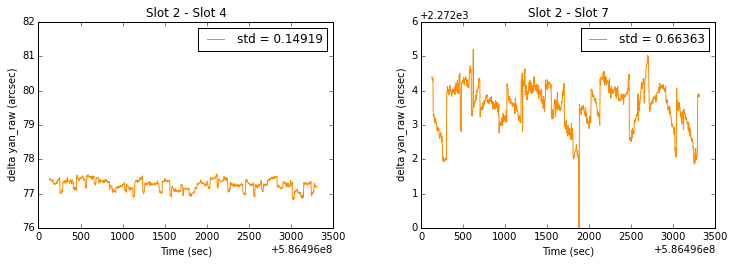

In [12]:
key = 'yan_raw'
plot_d_ang(key, dt, t)
print "Method: first moment"

In [13]:
# Use simple weighting mask
#wmask = gaussian_kernel_8x8(6)
wmask = get_weighting_mask_8x8_centered()
rows_wm = calc_raw_centroids_stats(slots, method='weighting_mask', wmask=wmask)

In [14]:
t_wm = Table(rows_wm)

Method: weighting mask


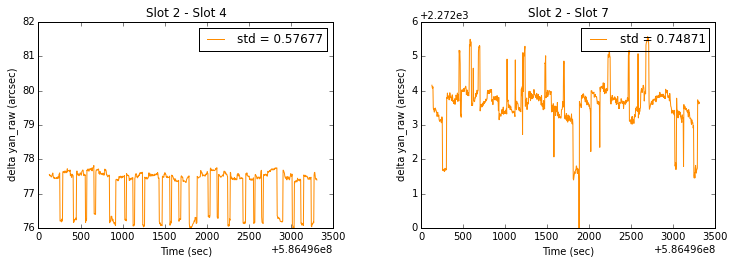

In [15]:
plot_d_ang(key, dt, t_wm)
print "Method: weighting mask"

Method: weighting mask only for the faint star in slot 7


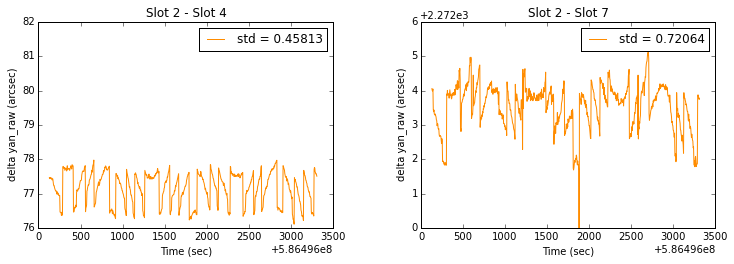

In [16]:
plot_d_ang(key, dt, t, t_wm)
print "Method: weighting mask only for the faint star in slot 7"